In [1]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from postamats.utils import prepare_data, helpers
from postamats.utils.connections import DB
from postamats.optimization import clustopt
from postamats.global_constants import APARTMENT_HOUSES_NAME, ALL_METRO_NAME, ALL_OBJECTS_NAME
from postamats.utils.connections import PATH_TO_ROOT

pd.set_option('display.max_columns', None)

In [2]:
# сколько всего постаматов в планах
TOTAL_POSTAMATS = 10**4
# какой радиус по умолчанию обслуживает 1 установленный постамат
MAX_ACTIVE_RADIUS = 400
MAX_POSTAMAT_AREA = np.pi * MAX_ACTIVE_RADIUS ** 2

In [3]:
CONFIG_PATH = os.path.join(PATH_TO_ROOT, 'db_config.json')
with open(CONFIG_PATH, mode='r') as db_file:
    db_config = json.load(db_file)
database = DB(db_config)

Загружаем базы

In [4]:
apart_query = "select object_id, lat, lon, object_type, population from public.apartment_houses_all_data"
metro_query = "select object_id_metro, lat, lon, object_type from public.all_metro_objects_data where object_type='кластер входов в метро'"
points_query = 'select object_id, lat, lon, object_type from public.all_objects_data'

In [5]:
all_apart = database.get_by_sql(apart_query)
all_metro = database.get_by_sql(metro_query)
all_points = database.get_by_sql(points_query)

Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Connection to PostgreSQL DB successful
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Эмулируем входящий json

In [6]:
# пусть мы собираемся поставить 500 постаматов
# мы выбрали 15000 точек для их расстановки
# и ещё 500 точек забанили
not_aparts_points = all_points[all_points['object_type']!='многоквартирный дом']
json_input = {
    'postamat_quant': 500,
    'possible_points': not_aparts_points['object_id'].to_list(),#all_points.sample(n=15000, random_state=0)['object_id'].to_list(),
    'fixed_points': not_aparts_points.sample(n=100, random_state=0)['object_id'].to_list(),
    'metro_priority': 0.5,
    'large_houses_priority': 0.5,
    'adm_area': [],
    'district': []
}

with open('json_input.json', 'w') as fp:
    json.dump(json_input, fp, indent=4)

In [7]:
with open('json_input.json', mode='r') as f:
    json_input = json.load(f)

possible_points = json_input['possible_points']
fixed_points = json_input['fixed_points']
postamat_quant = json_input['postamat_quant']

In [8]:
# Зафиксированные точки мы исключаем из расчета
# и исключаем дома вокруг них из оптимизации, т.к. считаем, что они уже обслуживаются установленной точкой
# для этого из таблицы APARTMENT_HOUSES_NAME исключаем жилые дома, расстояние от которых до точек,
# где уже стоит постамат, меньше порога

# расчет мы в любом случае делаем для TOTAL_POSTAMATS - fixed_points,
# но затем от всех полученных рекомендованных точек установки берем топ n_points_to_place по метрике

In [9]:
# считаем картезиановы координаты
all_apart_cartes = helpers.calc_cartesian_coords(all_apart['lat'], all_apart['lon'])
all_apart_cartes.index = all_apart.index
all_apart = all_apart.join(all_apart_cartes)

In [10]:
all_points_cartes = helpers.calc_cartesian_coords(all_points['lat'], all_points['lon'])
all_points_cartes.index = all_points.index
all_points = all_points.join(all_points_cartes)

In [11]:
# # теперь нам нужно исключить зафиксированные точки из возможных точек расстановки
cleaned_points = all_points[~all_points['object_id'].isin(fixed_points)]
# также надо взять только точки, доступные для установки
cleaned_points = cleaned_points[cleaned_points['object_id'].isin(possible_points)]

In [12]:
fixed_points_df = all_points.loc[all_points['object_id'].isin(fixed_points), :].copy()

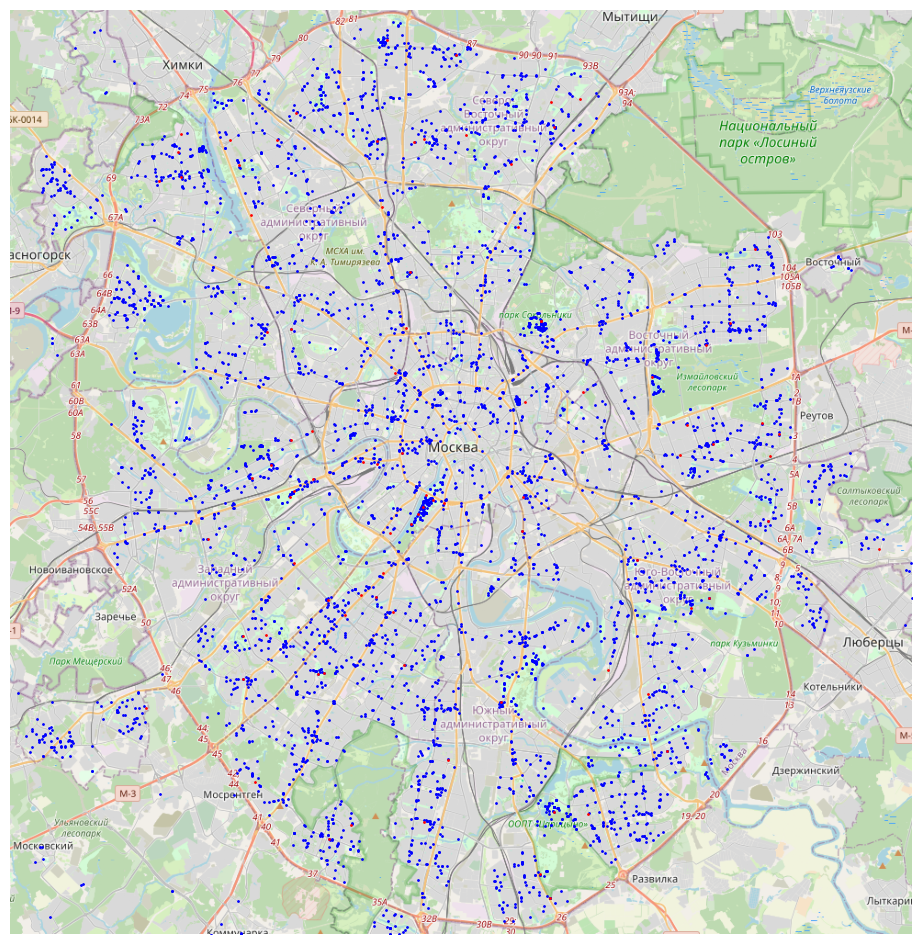

In [13]:
helpers.plot_map(cleaned_points, fixed_points_df, size1=1, size2=1, alpha1=1, alpha2=1)

In [14]:
# фильтруем данные о зификсированных точках
# удаляем из расчета те дома, которые уже обслуживаются постаматом
cleaned_apart = clustopt.remove_or_select_nearest(all_apart, fixed_points_df)

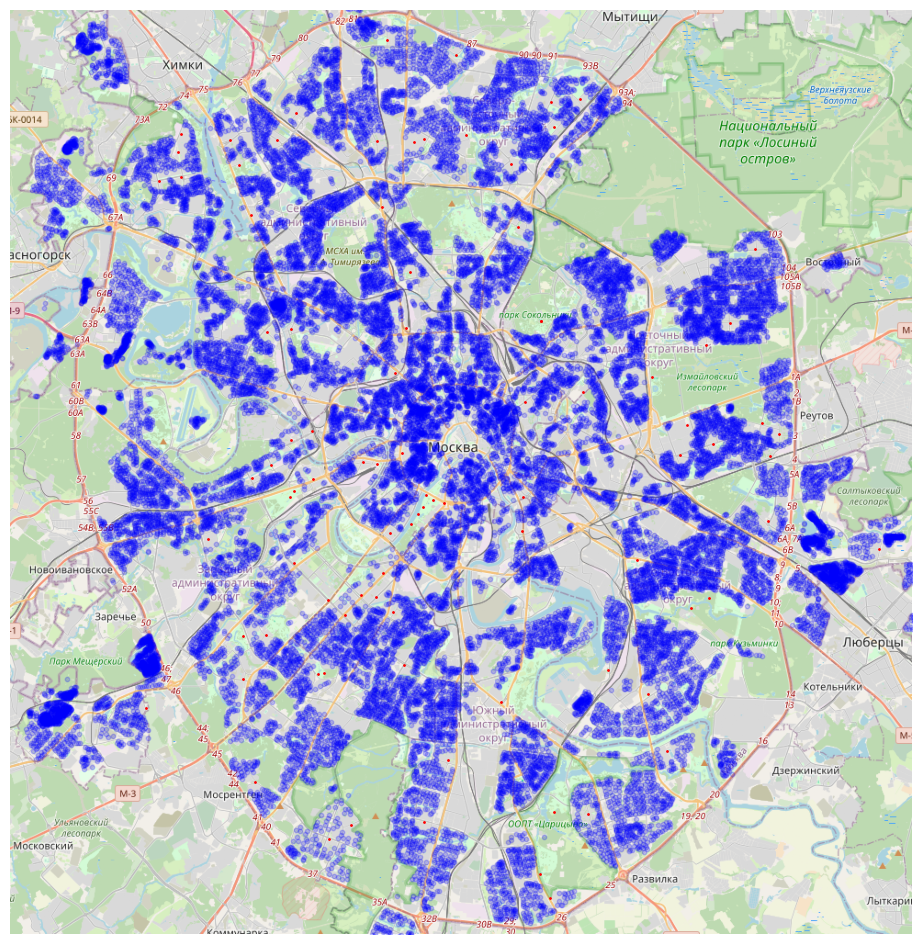

In [15]:
helpers.plot_map(cleaned_apart, fixed_points_df)

In [16]:
# Постаматы имеют эффективный радиус действия, оставляем только те дома,
# которые находятся в границах эффективного радиуса действия постаматов
# радиус берем с запасом 400 * 3 = 1200 м
cleaned_apart = clustopt.remove_or_select_nearest(cleaned_apart,
                                        cleaned_points,
                                        distance_threshold=3*MAX_ACTIVE_RADIUS,
                                        action='select')

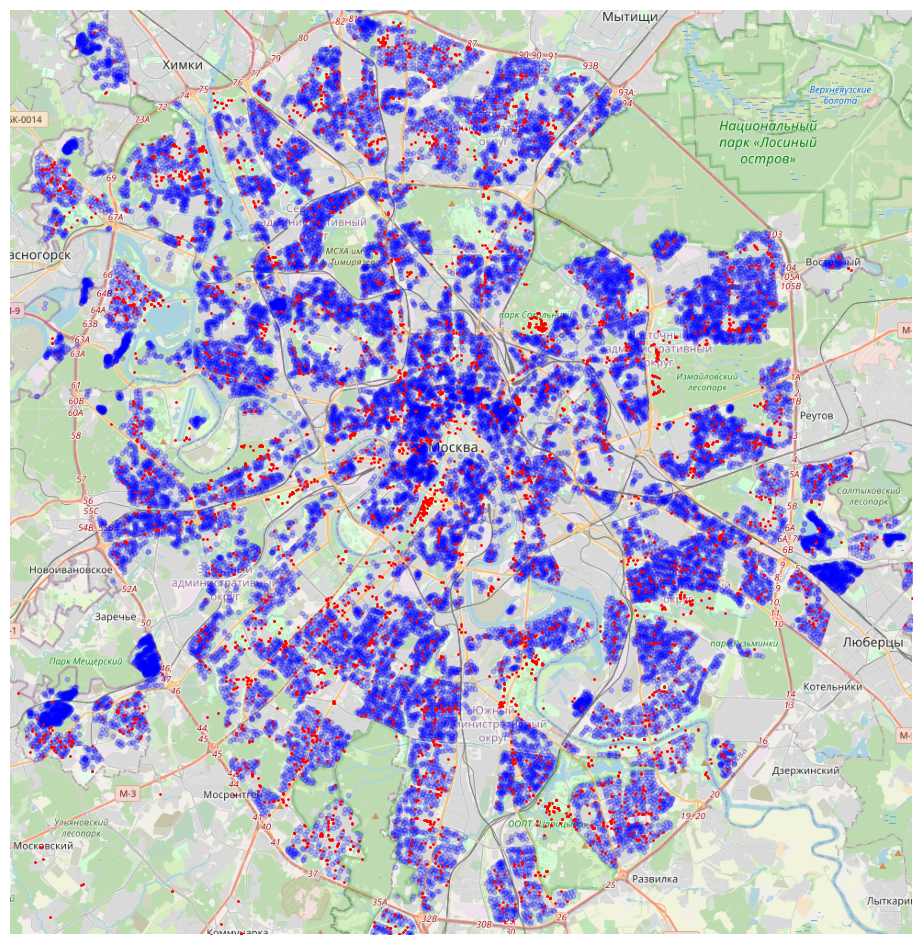

In [17]:
helpers.plot_map(cleaned_apart, cleaned_points)

In [18]:
apart_vs_points = pd.concat([cleaned_apart, cleaned_points], ignore_index=True)
apart_vs_points['is_point'] = apart_vs_points['object_id'].isin(cleaned_points['object_id'])
sample_weight = clustopt.calculate_weights(apart_vs_points)
sample_weight[apart_vs_points['is_point']] = 0

In [19]:
# теперь мы кластеризуем оставшиес точки притяжения
dbscan = DBSCAN(eps=400, min_samples=5)
labels=dbscan.fit_predict(apart_vs_points[['x', 'y']], sample_weight=sample_weight)
print(len(set(labels)))
apart_vs_points['label'] = labels

64


In [20]:
apart_wo_points = apart_vs_points[~apart_vs_points['is_point']].copy()
clusters_population_density, clusters_area, clusters_by_density = \
    clustopt.sort_clusters_by_density(apart_wo_points)

In [21]:
point_ids = []
remain_postamats_quant = 1000
for lbl in clusters_by_density:
    new_ids = []
    if remain_postamats_quant <= 0:
        break
    lbl_cond = apart_vs_points['label']==lbl
    new_ids = clustopt.set_cluster_postamats(apart_vs_points[lbl_cond], clusters_area[lbl], remain_postamats_quant)
    point_ids += new_ids
    remain_postamats_quant -= len(new_ids)

ValueError: n_samples=12 should be >= n_clusters=1000.

In [ ]:
plot_map(apart_vs_points, cleaned_points, c1=labels, c2='r', size2=2, alpha2=.7)
plot_map(apart_vs_points, all_points[all_points['object_id'].isin(point_ids)], c1=labels, c2='r', size2=130, alpha2=.7)